In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

y = 1. It's a cat picture.
train_x_orig.shape: (209, 64, 64, 3)

Number of training examples: 209
Number of testing examples: 50
Each image is: (64, 64, 3)

train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


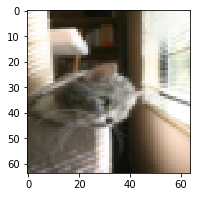

In [3]:
# Load dataset.
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
# Example of a picture
index = 166
plt.figure(num=1, figsize=(3,3))
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")
 
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]
print ("train_x_orig.shape: " + str(train_x_orig.shape))
print("")
print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

In [4]:
# Preprocess input data(images)
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
 
# Normalization data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
 
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [5]:
print(train_x.shape)
print(train_y.shape)

(12288, 209)
(1, 209)


In [6]:
def initial_par(n_x, n_h, n_y):
    np.random.seed(1)
    
    w1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros([n_h, 1])
    w2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros([n_y, 1])
    
    parameters = {"w1":w1, "b1":b1, "w2":w2, "b2":b2}
    
    return parameters



In [7]:
def forwardpass(X, parameters):
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(w1, X) + b1 #w1.shape = 12*12288, X.shape = 12288*209
    #output.shape = 12*209
    A1 = np.maximum(0, Z1) #ReLU
    Z2 = np.dot(w2, A1) + b2 #w2.shape = 12288*12, A1.shape = 12*209
    #output.shape = 12288*209
    A2 = 1/ (1+np.exp(-Z2)) # sigmoid
    
    cache = {"Z1":Z1, "Z2":Z2, "A1":A1, "A2":A2}
    
    return A2, cache

In [8]:
def compute_Loss(A2, Y, parameters):
    m = Y.shape[1] #number of class
    
    Loss = (1./m) *  (-np.dot(Y, np.log(A2).T) - np.dot(1-Y, np.log(1-A2).T))
    Loss = np.squeeze(Loss)
    
    return Loss

In [9]:
def backwardpass(parameters, cache, X, Y):
    m = X.shape[1]
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dA2 = -(np.divide(Y, A2) - np.divide(1-Y, 1-A2))
    sigmoid = 1 / (1+np.exp(-Z2))
    dZ2 = dA2 * sigmoid * (1-sigmoid)
    dw2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(w2.T, dZ2)
    dZ1 = np.array(dA1, copy=True)
    dZ1[Z1<0] = 0
    dw1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dw1": dw1, "dw2": dw2, "db1": db1, "db2": db2}
    return grads   
    

In [10]:
def update_parameter(parameters, grads, learning_rate = 1.2):
    dw1 = grads["dw1"]
    dw2 = grads["dw2"]
    db1 = grads["db1"]
    db2 = grads["db2"]
    
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    
    w1 = w1 - learning_rate * dw1
    w2 = w2 - learning_rate * dw2
    b1 = b1 - learning_rate * db1
    b2 = b2 - learning_rate * db2
    
    parameters = {"w1":w1, "b1":b1, "w2":w2, "b2":b2}
    return parameters

In [11]:
def NN_model(X, Y, n_h, num_iterations=5000, learning_rate=0.008, print_cost=False):
#X = train_X, Y= train_Y
    costs = []
    np.random.seed(1)
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    parameters = initial_par(n_x, n_h, n_y)
    
    for i in range(0, num_iterations):
        A2, cache = forwardpass(X, parameters)
        Loss = compute_Loss(A2, Y, parameters)
        graids = backwardpass(parameters, cache, X, Y)
        parameters = update_parameter(parameters, graids, learning_rate)
        
        if i % 500 == 0:
            costs.append(Loss)
            if print_cost:
                print("Cost after iteration {}: {}".format(i, Loss))
    # The latest iteration.
    print("Cost after iteration {}: {}".format(i, Loss))
    costs.append(Loss)
    
    plt.figure(num=1, figsize=(8,5))
    plt.semilogy(costs)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.title("Learning Rate = " + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6933973875299138
Cost after iteration 500: 0.5054817305127274
Cost after iteration 1000: 0.3024003130312214
Cost after iteration 1500: 0.10870519536443565
Cost after iteration 2000: 0.05241476625572783
Cost after iteration 2500: 0.030579250891514
Cost after iteration 3000: 0.020298297062625262
Cost after iteration 3500: 0.014677909646732656
Cost after iteration 4000: 0.01125374091103634
Cost after iteration 4500: 0.009004024929312904
Cost after iteration 4999: 0.007434871257776553


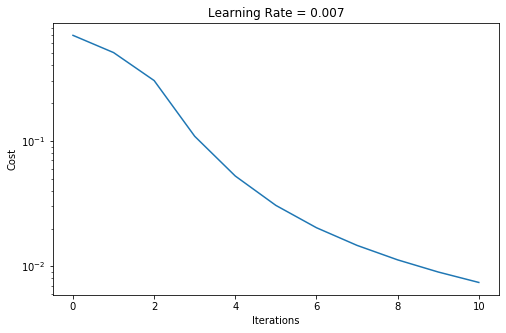

In [12]:
parameters = NN_model(train_x, train_y, 12, num_iterations=5000, learning_rate=0.007, print_cost=True)

In [13]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters)
    p = np.zeros((1,m))
    
    probas, caches = forwardpass(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    
    return p
            
    
    

In [14]:
print("Training accuracy:")
predictions_train = predict(train_x, train_y, parameters)
print("Testing accuracy:")
predictions_test = predict(test_x, test_y, parameters)

Training accuracy:
Accuracy: 0.9999999999999998
Testing accuracy:
Accuracy: 0.76


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


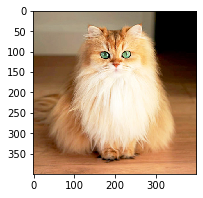

In [18]:
## START CODE HERE ##
# cat.jpg  my_image.jpg  people.jpeg
my_image = "cat.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = my_image
image = np.array(plt.imread(fname))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.figure(num=1, figsize=(3,3))
plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

In [19]:
#判斷錯誤的圖
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

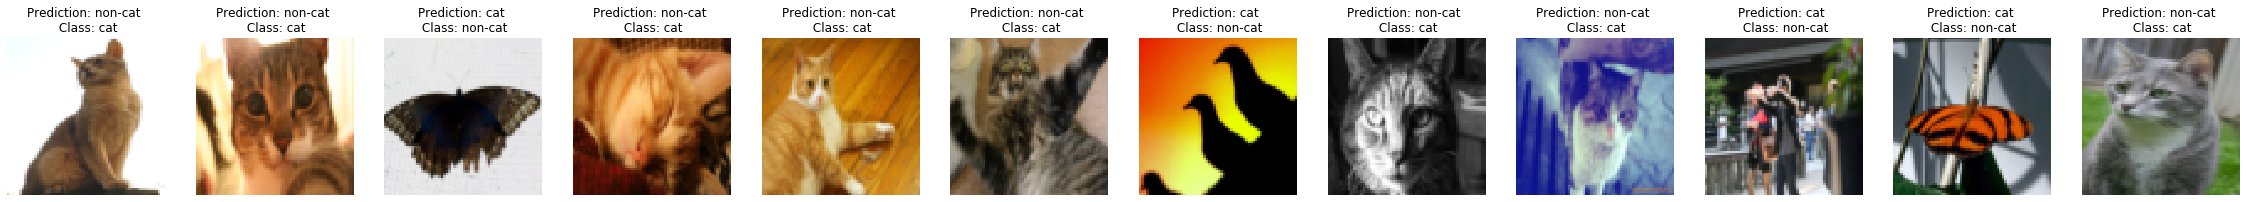

In [20]:
print_mislabeled_images(classes, test_x, test_y, predictions_test)